In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import networkx as nx
import numpy as np

from flatland.core.graph.graph_rendering import get_positions, add_flatland_styling
from flatland.core.graph.graph_simplification import DecisionPointGraph
from flatland.core.graph.grid_to_graph import GraphTransitionMap
from flatland.env_generation.env_generator import env_generator
from flatland.core.grid.rail_env_grid import RailEnvTransitions, RailEnvTransitionsEnum
from flatland.core.transition_map import GridTransitionMap
from flatland.utils.graphics_pil import PILSVG

In [3]:
mpl.rcParams['figure.max_open_warning'] = 0

# Flatland Graph Demo
This notebook illustrates the directed graph representation of Flatland.

A Flatland (microscopic) topology can be represented by different kinds of graphs.
The topology must reflect the possible paths through the rail network - it must not be possible to traverse a switch in the acute angle.
With the help of the graph it is very easy to calculate the shortest connection from node A to node B. The API makes it possible to solve such tasks very efficiently. Moreover, the graph can be simplified so that only decision-relevant nodes remain in the graph and all other nodes are merged. A decision node is a node or flatland cell (track) that reasonably allows the agent to stop, go, or branch off. For straight track edges within a route, it makes little sense to wait in many situations. This is because the agent would block many resources, i.e., if an agent does not drive to the decision point: a cell before a crossing, the agent blocks the area in between. This makes little sense from an optimization point of view.

Two (dual, equivalent) approaches are possible:
- agents are positioned on the nodes
- agents are positioned on the edges.
The second approach makes it easier to visualize agents moving forward on edges. Hence, we choose the second approach.

Our directed graph consists of nodes and edges:
* A node in the graph is defined by position and direction. The position corresponds to the position of the underlying cell in the original flatland topology, and the direction corresponds to the direction in which an agent reaches the cell. Thus, the node is defined by (r, c, d), where c (column) is the index of the horizontal cell grid position, r (row) is the index of the vertical cell grid position, and d (direction) is the direction of cell entry. In the Flatland (2d grid), not every of the eight neighbor cells can be reached from every direction. Therefore, the entry direction information is key.
* An edge is defined by "from-node" u and "to-node" v such that for the edge e = (u, v).  Edges reflect feasible transition from node u to node v. We can think of the suggestive notation $[u,v)$ in terms of resource occupation of the underlying cell, as the "from-node" refers to the underlying cell entered, and the "to-node" refers to the neighbor cell entered when the edge is left.

The implementation uses networkX, so there are also many graph functions available.

References:
- Egli, Adrian. FlatlandGraphBuilder. https://github.com/aiAdrian/flatland_railway_extension/blob/e2b15bdd851ad32fb26c1a53f04621a3ca38fc00/flatland_railway_extension/FlatlandGraphBuilder.py
- Nygren, E., Eichenberger, Ch., Frejinger, E. Scope Restriction for Scalable Real-Time Railway Rescheduling: An Exploratory Study. https://arxiv.org/abs/2305.03574


### Create env

In [4]:
env, _, _ = env_generator()

/Users/che/workspaces/flatland-rl-2/flatland/envs/rail_generators.py:321: UserWarning: Could not set all required cities! Created 1/2
  warnings.warn(city_warning)
/Users/che/workspaces/flatland-rl-2/flatland/envs/rail_generators.py:217: UserWarning: [WARNING] Changing to Grid mode to place at least 2 cities.
  warnings.warn("[WARNING] Changing to Grid mode to place at least 2 cities.")


## Transform to directed graph
The directed graph is an equivalent representation of the grid transition map. It reflects the railway topology, ie. the paths a train can take.

`GraphTransitionMap` represents a Flatland 3 transition map by a directed graph.

The grid transition map contains for all cells a set of pairs (heading at cell entry, heading at cell exit).
  E.g. horizontal straight is {(E,E), (W,W)}.
The directed graph's nodes are entry pins (cell + plus heading at entry).
Edges always go from entry pin at one cell to entry pin of a neighboring cell.
The outgoing heading for the grid transition map is the incoming heading at a neighboring cell.

Incoming heading:
```
               S
               ⌄
               |
       E   >---+---< W
               |
               ^
               N
```
Outgoing heading (=incoming at neighbor cell):
```
               N (of cell-to-the-north)
               ^
               |
       E   <---+---> E (of cell-to-the-east)
(of cell-to-   |
 the-east)     ⌄
               S (of cell-to-the-south)
```

In [5]:
micro = GraphTransitionMap.grid_to_digraph(env.rail)

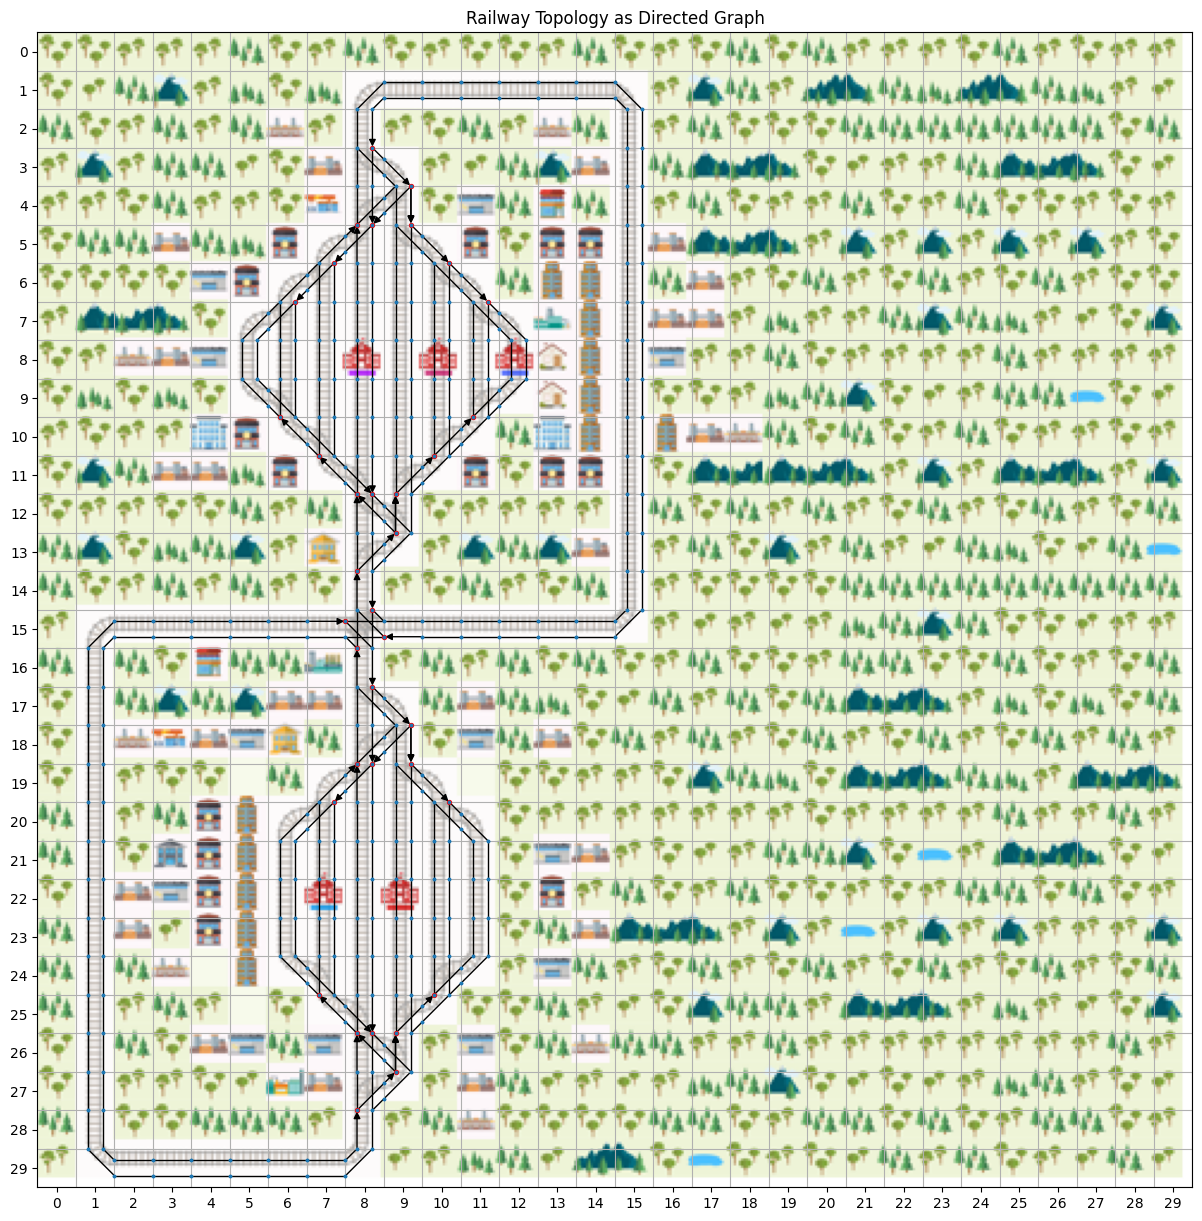

In [6]:
fig, ax = plt.subplots(1)
micro1 = nx.subgraph_view(micro, filter_edge=lambda u, v: len(list(micro.successors(v))) == 1)
nx.draw_networkx(micro1,
                 pos=get_positions(micro1),
                 ax=ax,
                 node_size=2,
                 with_labels=False,
                 arrows=False
                 )
micro2 = nx.subgraph_view(micro, filter_node=lambda v: len(list(micro.successors(v))) == 2)
nx.draw_networkx(micro2,
                 pos=get_positions(micro2),
                 ax=ax,
                 node_size=8,
                 node_color="red",
                 with_labels=False,
                 )
micro3 = nx.subgraph_view(micro, filter_edge=lambda u, v: len(list(micro.successors(v))) == 2)
nx.draw_networkx(micro3,
                 pos=get_positions(micro3),
                 ax=ax,
                 arrows=True,
                 node_size=3,
                 with_labels=False
                 )

add_flatland_styling(env, ax)

ax.set_title('Railway Topology as Directed Graph')

fig.set_size_inches(15,15)
# fig.savefig('graph_demo.png', dpi=100)

### Deep Dive Basic Railway Elements
Here are the 10 basic railway elements with their graph equivalent.

![title](./images/graph_to_digraph.drawio.png)

In [7]:
pil = PILSVG(1,1)

In [8]:
assert len(set([e.value for e in RailEnvTransitionsEnum])) == 30

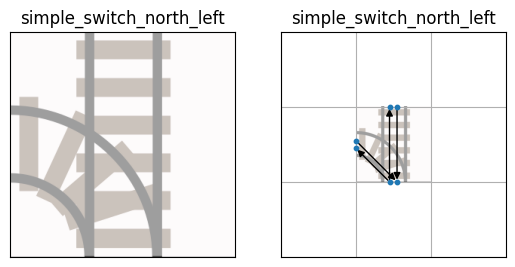

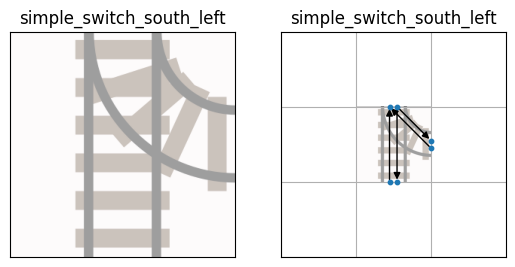

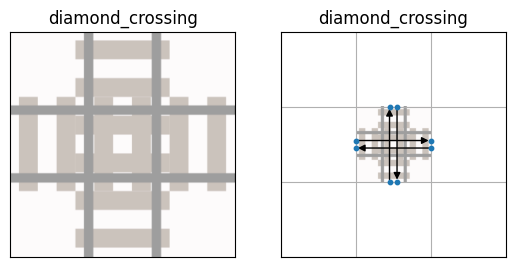

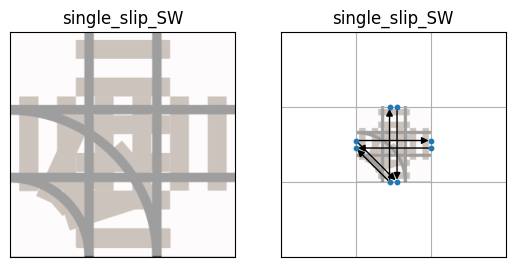

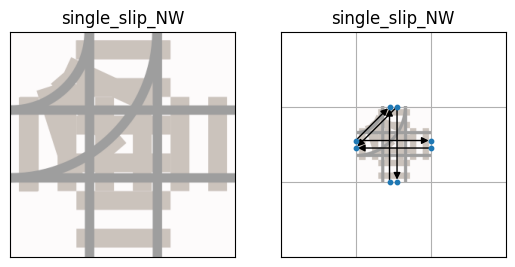

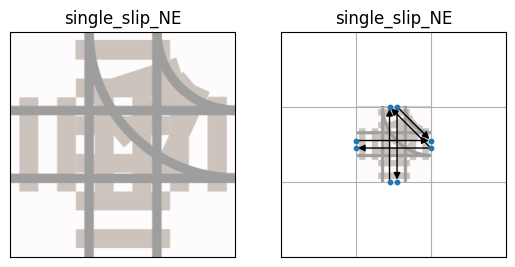

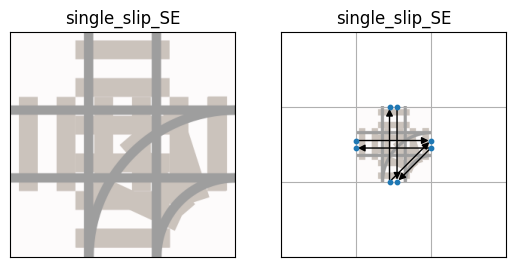

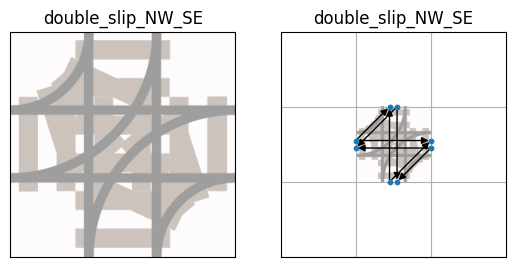

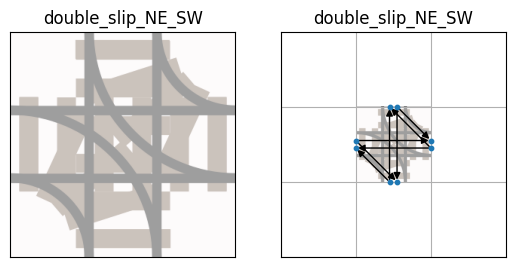

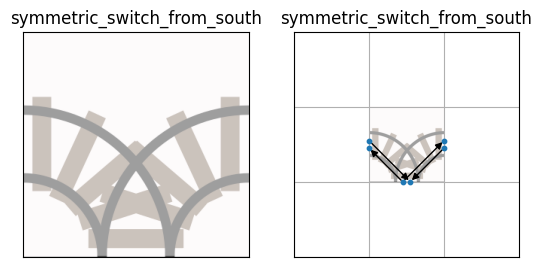

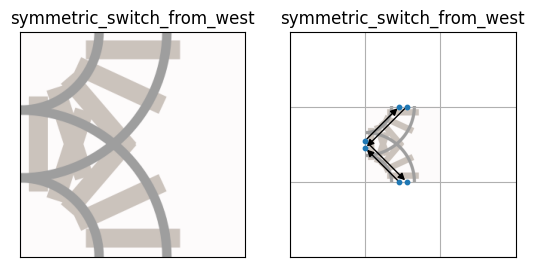

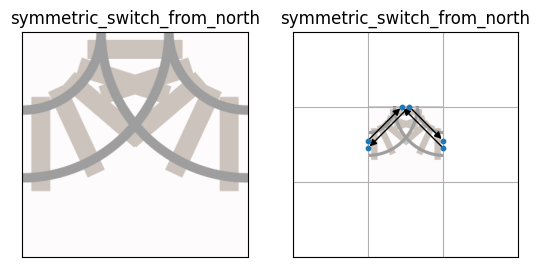

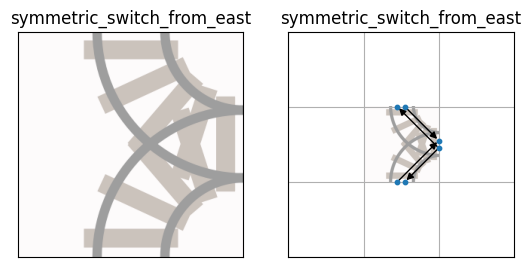

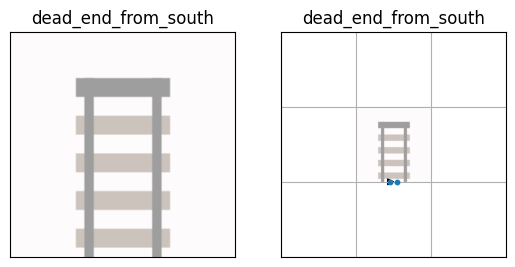

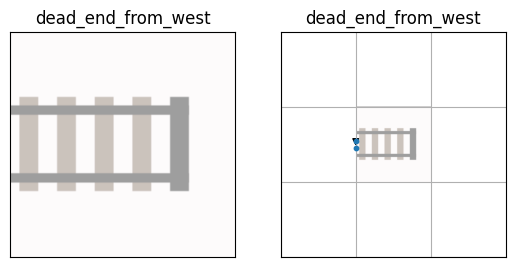

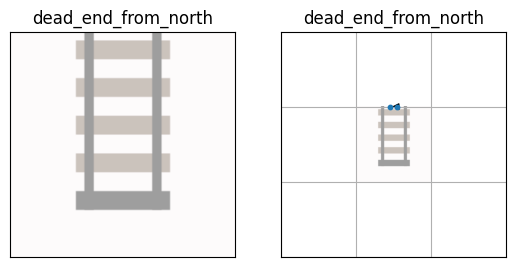

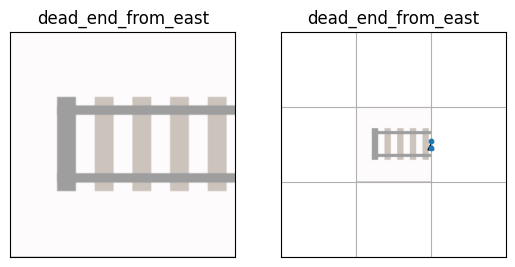

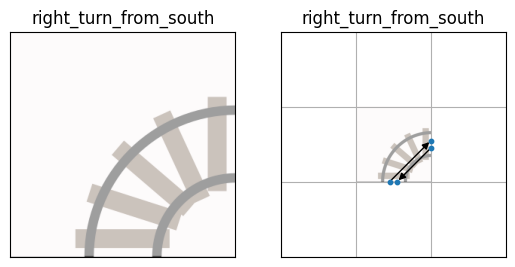

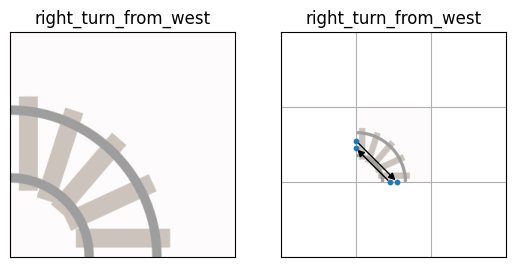

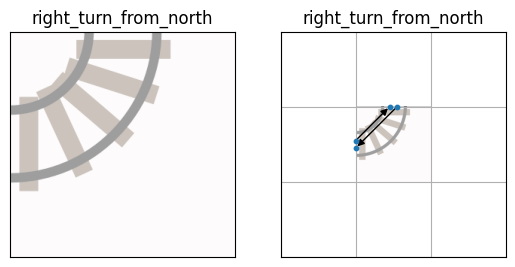

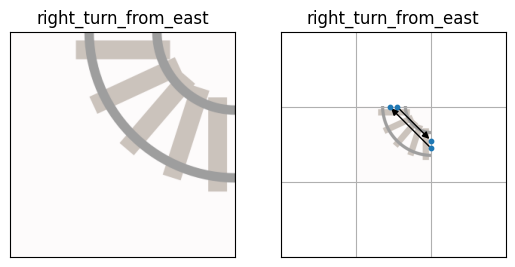

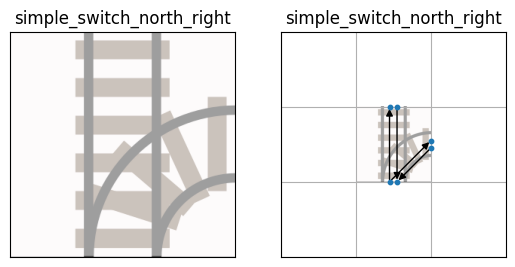

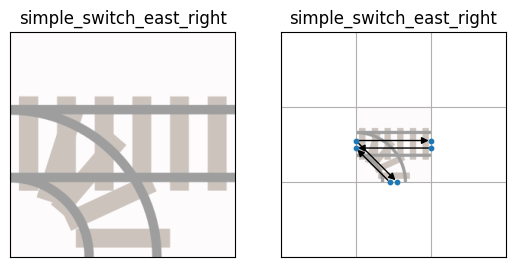

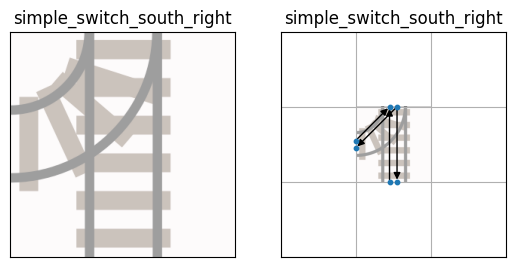

In [9]:
for i, e in enumerate(RailEnvTransitionsEnum):
    transition = e.value

    fig, axs = plt.subplots(1, 2)
    # use 3 x 3 not to go -1
    rail_map = np.array(
        [[RailEnvTransitionsEnum.empty] * 3] +
        [[RailEnvTransitionsEnum.empty, transition, RailEnvTransitionsEnum.empty]] +
        [[RailEnvTransitionsEnum.empty] * 3], dtype=np.uint16)

    gtm = GridTransitionMap(width=rail_map.shape[1], height=rail_map.shape[0], transitions=RailEnvTransitions())
    gtm.grid = rail_map

    img = pil.pil_rail[transition]

    axs[0].imshow(img, extent=[0.5, 1.5, 0.5, 1.5])
    axs[0].set_title(e.name)
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    
    ax = axs[1]
    ax.set_ylim(3 - 0.5, -0.5)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(0, 3, 1))
    
    img = np.fliplr(np.rot90(np.rot90(img))) # need to rotate back as we invert the y axis!
    ax.imshow(img, extent=[0.5, 1.5, 0.5, 1.5])
    ax.set_xticks(np.arange(-0.5, 2.5, 1), minor=True)
    ax.set_yticks(np.arange(2.5, -0.5, -1), minor=True)
    ax.set_xlim(-0.5,2.5)
    
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.grid(which="minor")
    ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
    ax.set_ylim(2.5,-0.5) # fix labels
    g = GraphTransitionMap.grid_to_digraph(gtm)

    nx.draw_networkx(
         g,
         pos=get_positions(g, delta=0.05),
         ax=ax,
         node_size=10,
         with_labels=False,
         #font_size=5,
         arrows=True
    )
    ax.set_title(e.name)

## Simplify Graph to Decision Point Graph

`DecisionPointGraph` is an overlay on top of Flatland 3 grid where consecutive cells where agents cannot choose between alternative paths are collapsed into a single edge.
A reference to the underlying grid nodes is maintained.
The edge length is the number of cells "collapsed" into this edge.

In [10]:
gtm = GraphTransitionMap(micro)
decision_point_graph = DecisionPointGraph.fromGraphTransitionMap(gtm)
collapsed = decision_point_graph.g

## Comparison

In [11]:
fig, axs = plt.subplots(1, 2)
micro1 = nx.subgraph_view(micro, filter_edge=lambda u, v: len(list(micro.successors(v))) == 1)
nx.draw_networkx(micro1,
                 pos=get_positions(micro1),
                 ax=axs[0],
                 node_size=2,
                 with_labels=False,
                 arrows=False
                 )
micro2 = nx.subgraph_view(micro, filter_node=lambda v: len(list(micro.successors(v))) == 2)
nx.draw_networkx(micro2,
                 pos=get_positions(micro2),
                 ax=axs[0],
                 node_size=8,
                 node_color="red",
                 with_labels=False,
                 )
micro3 = nx.subgraph_view(micro, filter_edge=lambda u, v: len(list(micro.successors(v))) == 2)
nx.draw_networkx(micro3,
                 pos=get_positions(micro3),
                 ax=axs[0],
                 arrows=True,
                 node_size=1,
                 with_labels=False
                 )

nx.draw_networkx(collapsed,
                 pos=get_positions(collapsed),
                 ax=axs[1],
                 node_size=2,
                 with_labels=False
                 )
add_flatland_styling(env, axs[1])
add_flatland_styling(env, axs[0])

axs[0].set_title('micro')
axs[1].set_title('collapsed')

fig.set_size_inches(30,15)
# fig.savefig('graph_demo.png', dpi=100)